In [17]:
# Imports
import xarray as xr
import pandas as pd
import numpy as np
import os
import re
import seaborn as sns
import matplotlib.pyplot as plt

In [18]:
# Globals
month_to_num = {
    "Jan":1,
    "Feb":2,
    "Mar":3,
    "Apr":4,
    "May":5,
    "Jun":6,
    "Jul":7,
    "Aug":8,
    "Sep":9,
    "Oct":10,
    "Nov":11,
    "Dec":12,
}
num_to_month = {
    1:"Jan",
    2:"Feb",
    3:"Mar",
    4:"Apr",
    5:"May",
    6:"Jun",
    7:"Jul",
    8:"Aug",
    9:"Sep",
    10:"Oct",
    11:"Nov",
    12:"Dec",
}

In [19]:
def skill_at_cell(input_dir: str, lat: float, lon: float, lead: str) -> pd.DataFrame:
    read_data = []

    # List of netCDF files in the directory
    nc_files = [file for file in os.listdir(input_dir) if file.endswith(".nc")]

    # To sort months
    def get_month_num_from_name(file_name):
        match = re.match(r'([A-Za-z]{3})IC_.*\.nc', file_name)
        if match:
            month_abbr = match.group(1)
            return month_to_num.get(month_abbr, 0) #default to 0 for debugging
        return 0
    
    # Functional key for sorting based on month
    nc_files.sort(key=get_month_num_from_name)
    
    for file_name in nc_files:
        file_path = os.path.join(input_dir, file_name)

        # Get month abbreviation from the file name
        month_abbr_match = re.match(r'([A-Za-z]{3})IC_.*\.nc', file_name)
        # Debugging print
        if not month_abbr_match:
            print(f"Could not match month abbreviation from '{file_name}'.")
            continue

        month_abbr = month_abbr_match.group(1)
        month_num = month_to_num.get(month_abbr)

        # Debugging print
        if month_num is None:
            print(f"No number for month '{month_abbr}'. Check dictionary.")
            continue

        try:
            #open file like in "to_open_netcdf.ipynb"
            ds = xr.open_dataset(file_path, decode_times=False)

            skill_value = ds[f'{lead}'].sel(lat=lat, lon=lon, method="nearest").item()

            read_data.append({
                "month_name":num_to_month[month_num],
                f"{lead}":skill_value,
            })

        except KeyError as ke:
            print(f"KeyError in '{file_name}', check variable name. {ke}.")
        except Exception as e:
            print(f"Error processing '{file_name}': {e}.")
    
    # Dataframe to be returned
    result_df = pd.DataFrame(read_data)
    
    # Ensure month_name is a categorical type for proper sorting
    month_order = [num_to_month[i] for i in sorted(num_to_month.keys())]
    result_df['month_name'] = pd.Categorical(result_df['month_name'], categories=month_order, ordered=True)
    result_df = result_df.sort_values('month_name').reset_index(drop=True)

    return result_df

In [20]:
def convert_lon(lon: float) -> float:
    return float((lon + 360) % 360)

In [ ]:
# Testing call
input_dir = "prod/CFSv2/converted/"
lat = 18.0
lon = -66.0

lon = convert_lon(lon)

data = skill_at_cell(input_dir, lat, lon)





   month_name       sk1
0         Jan -0.128408
1         Feb  0.168572
2         Mar  0.141039
3         Apr -0.081630
4         May  0.443038
5         Jun  0.419011
6         Jul  0.415822
7         Aug  0.615963
8         Sep  0.087665
9         Oct  0.041964
10        Nov  0.165127
11        Dec -0.075814


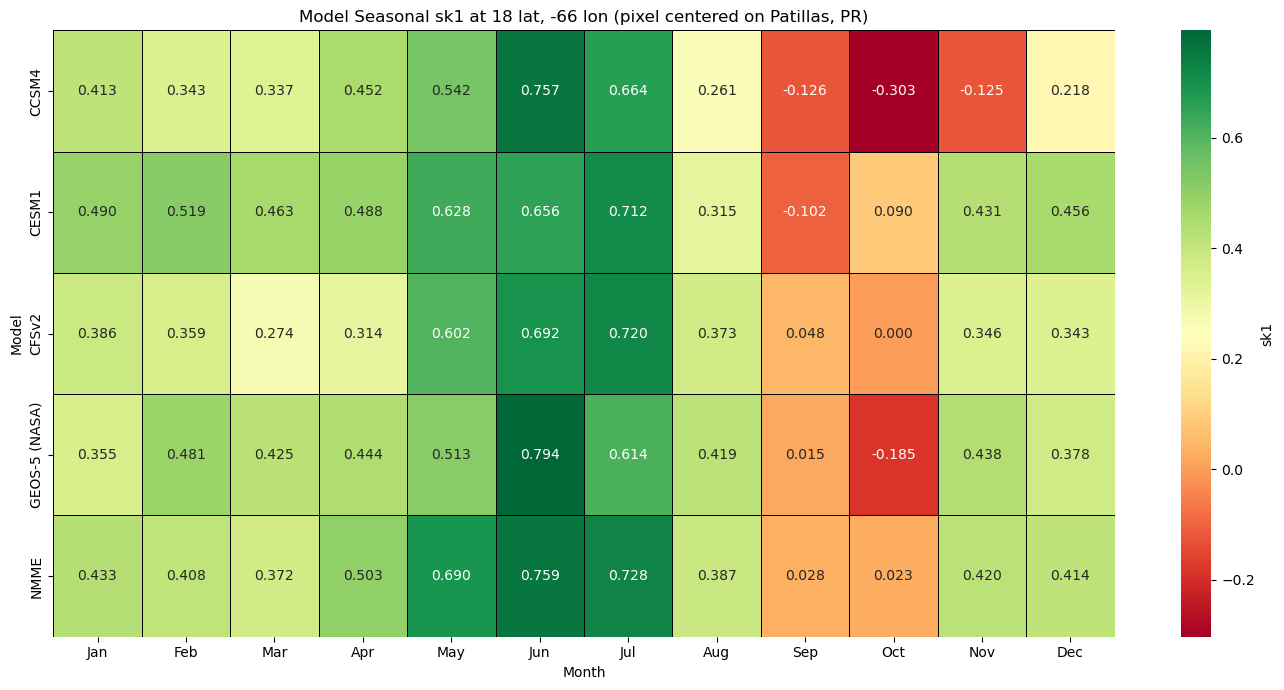

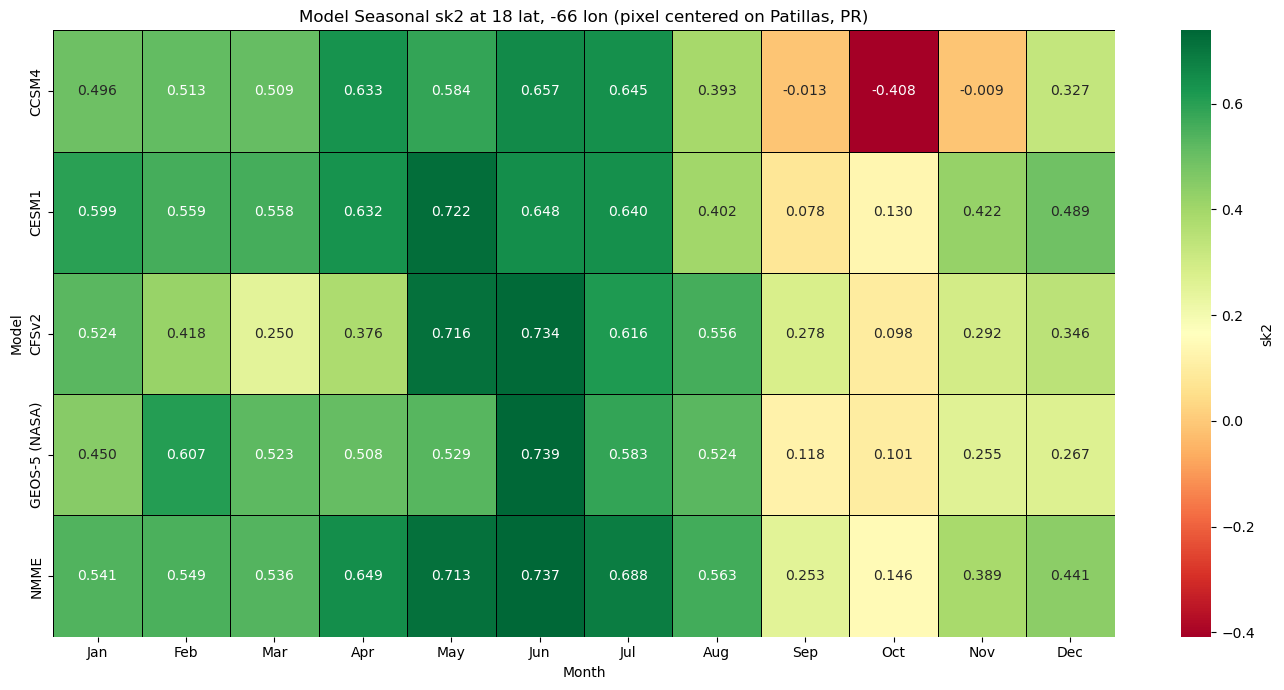

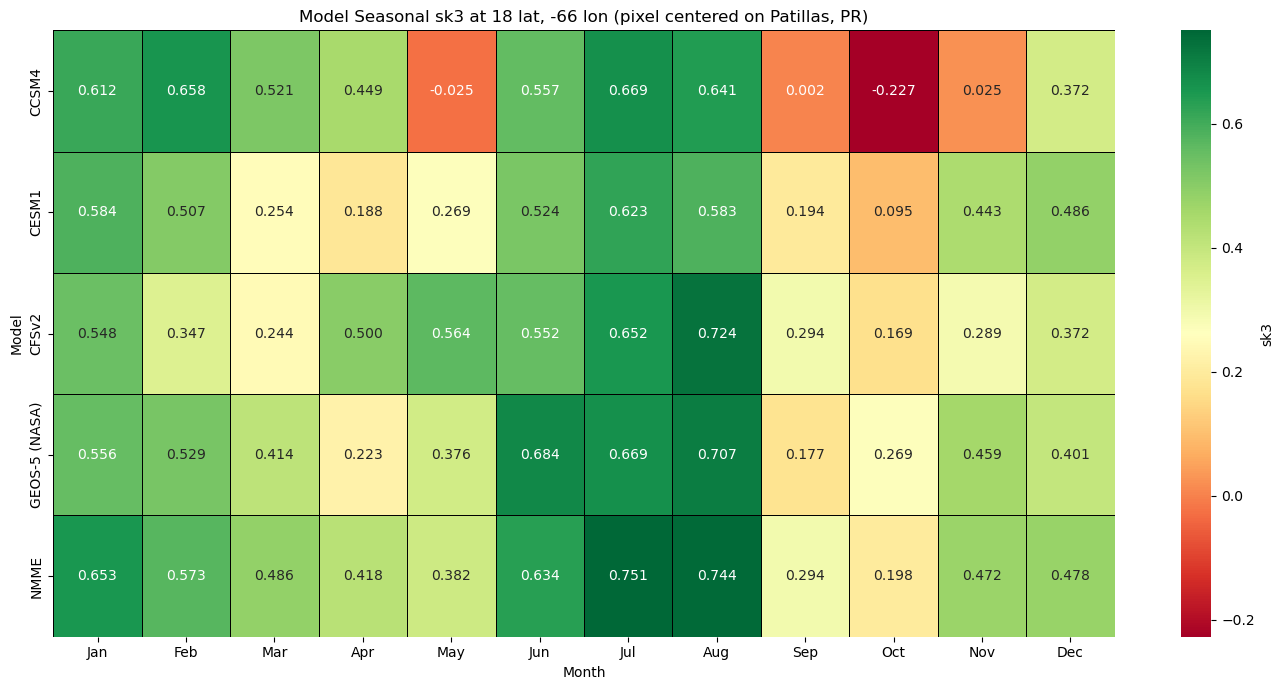

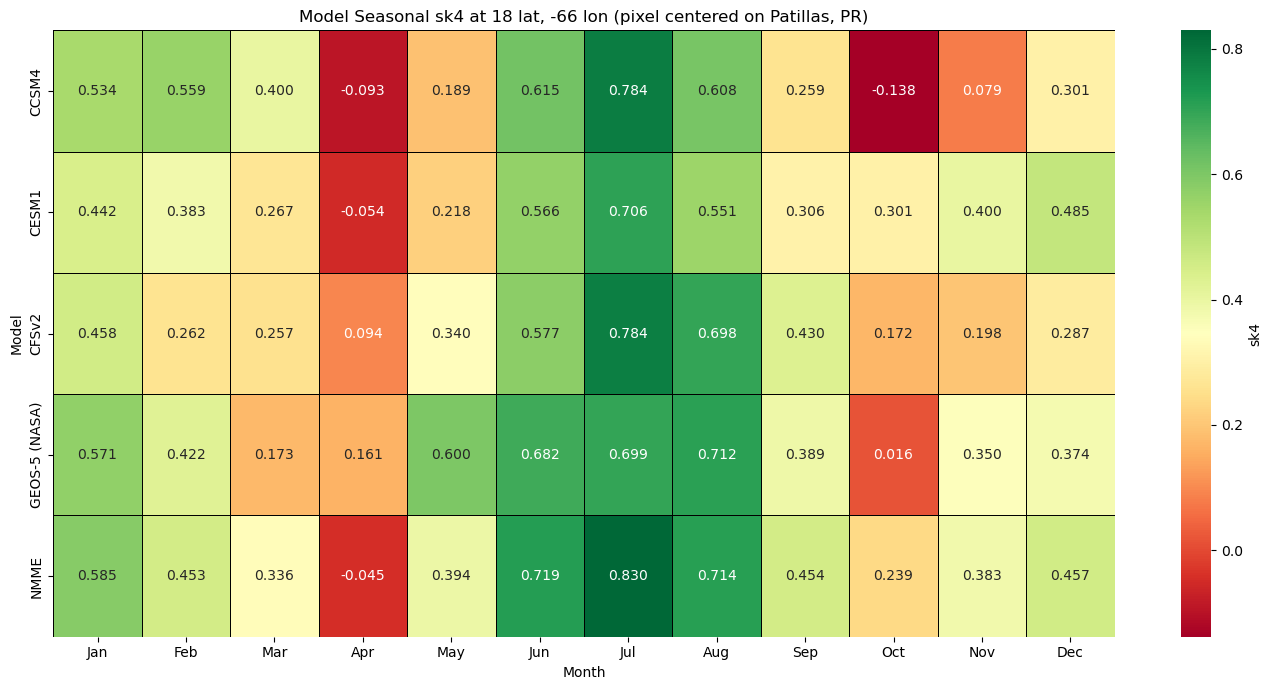

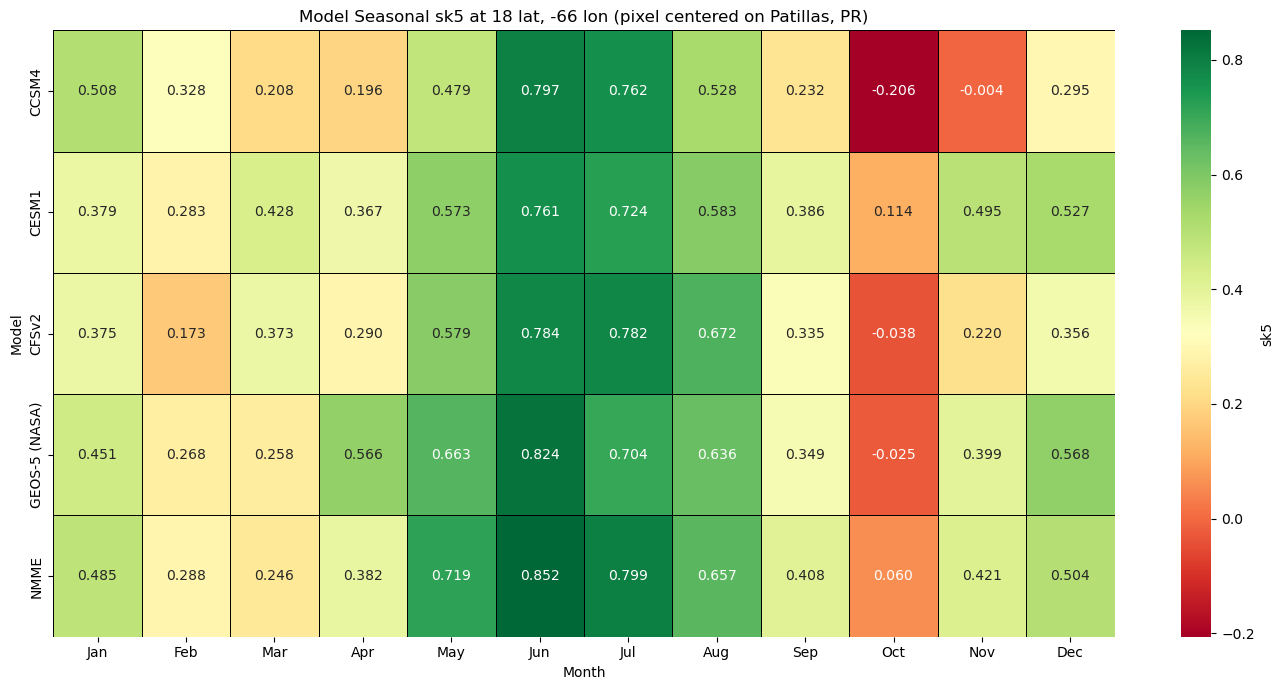

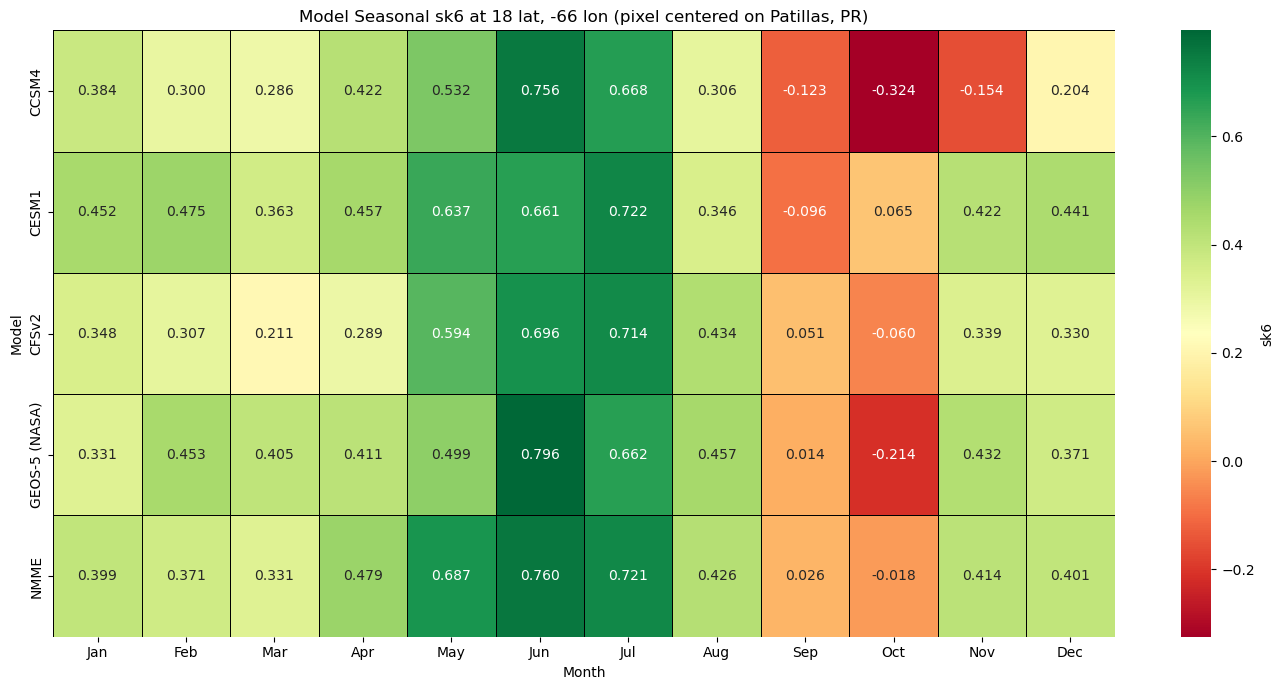

In [29]:
# Selecting a single pixel
lat = 18.0
lon = -66.0

lon = convert_lon(lon)

# Change the list up to 8 if monthly, 6 if seasonal
for lead in ["sk1", "sk2", "sk3", "sk4", "sk5", "sk6"]:
    # List to store the different model dataframes
    df_list = []
    
    for model_name in ["NMME", "CFSv2", "CCSM4", "CESM1", "GEOS-5 (NASA)"]:
        # Change this line if plotting seasonal or monthly
        input_dir = f"testing_seasonal/{model_name}/converted_focused/"
        # input_dir = f"prod/{model_name}/converted_focused/"

        df = skill_at_cell(input_dir, lat, lon, lead)
        # Adding a model column
        df["model"] = model_name
        df_list.append(df)

    # Concatenating all dataframes into one
    all_models_df = pd.concat(df_list)

    # To sort months into categories
    month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    all_models_df['month_name'] = pd.Categorical(all_models_df['month_name'], categories=month_order, ordered=True)


    # Flipping the dataframe
    data = all_models_df.pivot(index="model", columns="month_name", values=f"{lead}")
    plt.figure(figsize=(14, 7))
    sns.heatmap(data=data, annot=True, fmt=".3f", linewidths=0.5, linecolor="black", 
                cmap="RdYlGn", cbar_kws={"label": f"{lead}"})
    
    # Change 'Monthly' or 'Seasonal'
    plt.title(f"Model Seasonal {lead} at 18 lat, -66 lon (pixel centered on Patillas, PR)")
    plt.xlabel("Month")
    plt.ylabel("Model")
    plt.tight_layout()

    # Change if monthly or seasonal
    # plt.savefig(f"prod/plots/heatmaps/Model Monthly {lead}")
    plt.savefig(f"testing_seasonal/plots/heatmaps/Model Seasonal {lead}")
    
    # Trash collection
    del df
    del all_models_df
    del data
    